In [1]:
pip install pyTsetlinMachine

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PyTsetlinMachineCUDA

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PyTsetlinMachineCUDA.tm import MultiClassConvolutionalTsetlinMachine2D
import PyTsetlinMachineCUDA.tm
import pyTsetlinMachine
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.signal import spectrogram
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix
import json

In [ ]:
json_file = 'TM_CWRU_CTM_thermometer_avg.json' # Stores the result in here
directory_path = "../data/CWRU/Faulty" # Path to CWRU files

In [4]:
def load_mat_spectrogram(mat_file_path, num_bits, std_num=3, target_shape=(245, 1000)):
    """
    Load a spectrogram from a MATLAB file, process it through stretching, standardizing, normalizing, and
    encode it using thermometer encoding.

    Parameters:
    mat_file_path (str): Path to the MATLAB file containing the spectrogram.
    num_bits (int): Number of bits for thermometer encoding.
    std_num (int): Number of standard deviations for clipping during standardization.
    target_shape (tuple): Desired output shape (height, width) of the spectrogram.

    Returns:
    np.array: A array representing the encoded spectrogram.
    """
    # Load the spectrogram from the specified .mat file.
    mat_contents = scipy.io.loadmat(mat_file_path)
    spectrogram = mat_contents['spectrogram']

    # Calculate the zoom factors to resize the spectrogram to the target shape.
    zoom_factor_y = target_shape[0] / spectrogram.shape[0]
    zoom_factor_x = target_shape[1] / spectrogram.shape[1]

    # Stretch the spectrogram to the target shape using interpolation.
    stretched_y = zoom(spectrogram, (zoom_factor_y, zoom_factor_x))

    # Clip the stretched spectrogram's values to limit extreme deviations.
    avg_y = np.mean(stretched_y)
    std_y = np.std(stretched_y)
    clean_y = np.clip(stretched_y, avg_y - std_num * std_y, avg_y + std_num * std_y)

    # Normalize the clipped values to range between 0 and 1.
    clean_y_min = np.min(clean_y)
    clean_y_max = np.max(clean_y)
    norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

    # Define the thermometer encoding function.
    def thermometer_encode(values, num_bits):
        # Generate threshold values for encoding.
        thresholds = np.linspace(0, 1, num_bits + 1, endpoint=False)[1:]
        
        # Prepare values for vectorized comparison against thresholds.
        values_expanded = values[:, :, np.newaxis]
        
        # Perform vectorized comparison to generate encoded array.
        encoded = (values_expanded >= thresholds).astype(int)
        
        return encoded

    # Apply thermometer encoding to the normalized spectrogram.
    encoded_spectrogram = thermometer_encode(norm_y, num_bits)
    
    # Transpose to adjust dimensions for further processing.
    encoded_spectrogram = np.transpose(encoded_spectrogram, (1, 0, 2))
    return encoded_spectrogram

In [5]:
def spectrogram_size(mat_file_path):
    """
    Calculate the number of time frames in a spectrogram stored within a MATLAB file.

    Parameters:
    mat_file_path (str): The file path to the .mat file containing the spectrogram data.

    Returns:
    int: The number of time frames in the spectrogram.
    """
    # Load the spectrogram data from a .mat file.
    mat_contents = scipy.io.loadmat(mat_file_path)
    
    # Access the spectrogram data from the file contents.
    spectrogram = mat_contents['spectrogram']
    
    # Return the number of time frames, which is the number of rows in the spectrogram array.
    return spectrogram.shape[0]

In [6]:
def process_spectrograms(labels, file_paths, k_width, bits):
    """
    Process spectrogram files into sequences for machine learning models. This involves reshaping each spectrogram
    based on a window width (k_width) and the number of bits used in encoding.

    Parameters:
    labels (list): A list of labels corresponding to each spectrogram.
    file_paths (list): A list of paths to spectrogram files.
    k_width (int): The number of consecutive slices to include in each window of the output array.
    bits (int): The number of bits used in encoding the spectrogram, influencing the number of channels.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - x_data: Array of reshaped spectrogram data for model input.
           - y_data: Array of labels corresponding to each window of spectrogram data.
    """
    x_data = []
    y_data = []

    # Process each file and label pair.
    for label, path in zip(labels, file_paths):
        # Load the spectrogram which is already encoded into bit format.
        spectrogram = load_mat_spectrogram(path, bits)
        print("Spectrogram shape before processing:", spectrogram.shape)

        # Dimensions of the loaded spectrogram
        time_slices, frequency_bins, channels = spectrogram.shape

        # Adjust the number of time slices to ensure it is divisible by k_width.
        if time_slices % k_width != 0:
            spectrogram = spectrogram[:-(time_slices % k_width)]

        # Calculate the new number of time slices after trimming.
        new_time_slices = time_slices - (time_slices % k_width)

        # Initialize an empty array for storing reshaped data.
        reshaped_data = np.empty((new_time_slices - k_width + 1, k_width, frequency_bins, channels))

        # Populate the reshaped data array with windows of spectrogram slices.
        for i in range(new_time_slices - k_width + 1):
            reshaped_data[i] = spectrogram[i:i + k_width]

        # Append the reshaped spectrogram and corresponding label to the output lists.
        x_data.append(reshaped_data)
        y_data.append(label)

    # Convert lists to numpy arrays for handling varying sizes.
    x_data = np.array(x_data, dtype=object)
    y_data = np.array(y_data, dtype=object)

    return x_data, y_data


In [7]:
# Define sets for different types of faults identified by specific ball and roller positions in bearings
ball_numbers = {123, 124, 125, 190, 191, 192, 227, 228, 229}
inner_numbers = {110, 111, 112, 175, 176, 177, 214, 215, 217}
outer_numbers = {136, 137, 138, 202, 203, 204, 239, 240, 241}
test = [229,217,138]
labels = []  
# Number of bits for thermometer encoding
bits = 8 
# Define window size of the data augmentation
k_width = 2
min_spectogram_height = 200
file_paths = [

]

labels_test = []
file_paths_test = [

]

c = 0

# Process each file in the directory
for filename in os.listdir(directory_path):
    if c > 36:  # Limit the number of files processed
        break

    # Extract the numeric part of the filename
    digit_str = ''.join(filter(str.isdigit, filename))
    if not digit_str:  # Ignore files without numbers
        continue
    number = int(digit_str)

    # Assign labels based on the number extracted from the filename
    if number in ball_numbers:
        label = 0
    elif number in inner_numbers:
        label = 1
    elif number in outer_numbers:
        label = 2
    else:
        label = None  # Ignore files that don't match the expected categories
    
    if label is not None:  # Only process files with a valid label
        file_path = os.path.join(directory_path, filename)
        if number not in test:
            # Add the file to the training set if it meets the height requirement
            if spectrogram_size(file_path) > min_spectogram_height:
                labels.append(label)
                file_paths.append(file_path)
            else:
                # Output the file path if the height is insufficient (for debugging)
                print(file_path)
            c += 1
        else:
            # Add the file to the testing set if it meets the height requirement
            file_path_test = os.path.join(directory_path, filename)
            if spectrogram_size(file_path_test) > min_spectogram_height:
                labels_test.append(label)
                file_paths_test.append(file_path_test)
            else:
                # Output details for debugging
                print(spectrogram_size(file_path_test))
                print(file_path_test)
            c += 1


# Process spectrograms and prepare data arrays
x_data, y_data = process_spectrograms(labels, file_paths, k_width, bits)
x_data_test, y_data_test = process_spectrograms(labels_test, file_paths_test, k_width, bits)

# Combine all sequence data into a single array for training and testing
x_data = np.vstack(x_data)
x_data_test = np.vstack(x_data_test)

# Reshape data into a flat format suitable for model input
flattened_data = x_data.reshape(-1, x_data.shape[1] * x_data.shape[2], x_data.shape[3])
flattened_data_test = x_data_test.reshape(-1, x_data_test.shape[1] * x_data_test.shape[2], x_data_test.shape[3])

# Repeat labels for each segment in the processed data
repeated_y_data = np.repeat(y_data, 1000 - (k_width - 1)).reshape(-1, 1000 - (k_width - 1))
repeated_y_data_test = np.repeat(y_data_test, 1000 - (k_width - 1)).reshape(-1, 1000 - (k_width - 1))

# Flatten label arrays for consistency with the input data
repeated_y_data = repeated_y_data.flatten()
repeated_y_data_test = repeated_y_data_test.flatten()

Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram shape before processing: (1000, 245, 8)
Spectrogram 

In [8]:
print(x_data.shape)
print(x_data_test.shape)
print(flattened_data.shape)
print(flattened_data_test.shape)
print(repeated_y_data.shape)
print(repeated_y_data_test.shape)

(23976, 2, 245, 8)
(2997, 2, 245, 8)
(23976, 490, 8)
(2997, 490, 8)
(23976,)
(2997,)


Epoch 1 Accuracy: 88.49%
Epoch 1 Accuracy for unseendata: 93.13%
Epoch 2 Accuracy: 93.10%
Epoch 2 Accuracy for unseendata: 91.89%
Epoch 3 Accuracy: 94.22%
Epoch 3 Accuracy for unseendata: 95.43%
Epoch 4 Accuracy: 95.16%
Epoch 4 Accuracy for unseendata: 95.93%
Epoch 5 Accuracy: 95.27%
Epoch 5 Accuracy for unseendata: 96.90%
Epoch 6 Accuracy: 95.25%
Epoch 6 Accuracy for unseendata: 96.53%
Epoch 7 Accuracy: 95.33%
Epoch 7 Accuracy for unseendata: 95.43%
Epoch 8 Accuracy: 95.64%
Epoch 8 Accuracy for unseendata: 96.10%
Epoch 9 Accuracy: 95.89%
Epoch 9 Accuracy for unseendata: 95.63%
Epoch 10 Accuracy: 95.60%
Epoch 10 Accuracy for unseendata: 94.26%
Epoch 11 Accuracy: 96.00%
Epoch 11 Accuracy for unseendata: 97.36%
Epoch 12 Accuracy: 95.87%
Epoch 12 Accuracy for unseendata: 97.20%
Epoch 13 Accuracy: 95.85%
Epoch 13 Accuracy for unseendata: 96.70%
Epoch 14 Accuracy: 96.33%
Epoch 14 Accuracy for unseendata: 95.73%
Epoch 15 Accuracy: 96.68%
Epoch 15 Accuracy for unseendata: 96.83%
Epoch 16 Accu

/tmp/ipykernel_758677/2156954925.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(x='Epoch', y='Accuracy', data=data, marker='o', palette="tab10", linewidth=2.5)


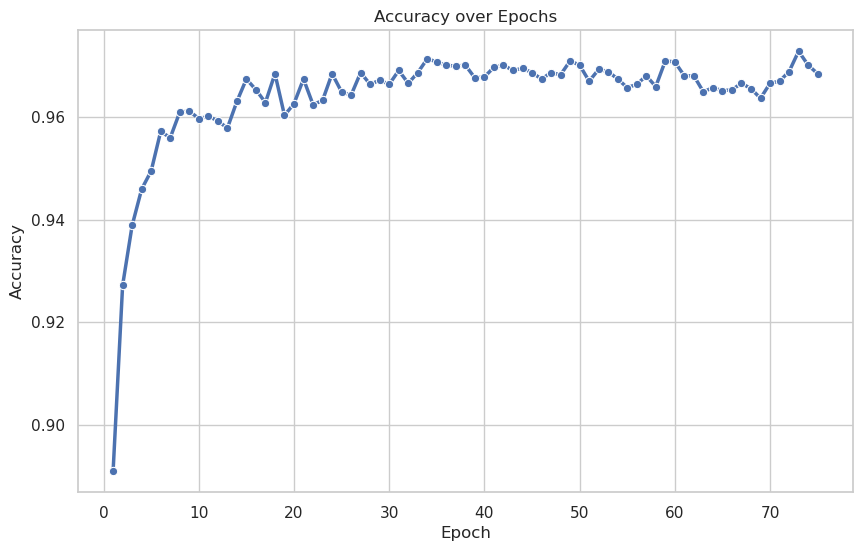

/tmp/ipykernel_758677/2156954925.py:79: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(x='Epoch', y='Accuracy', data=data_unseen, marker='o', palette="tab10", linewidth=2.5)


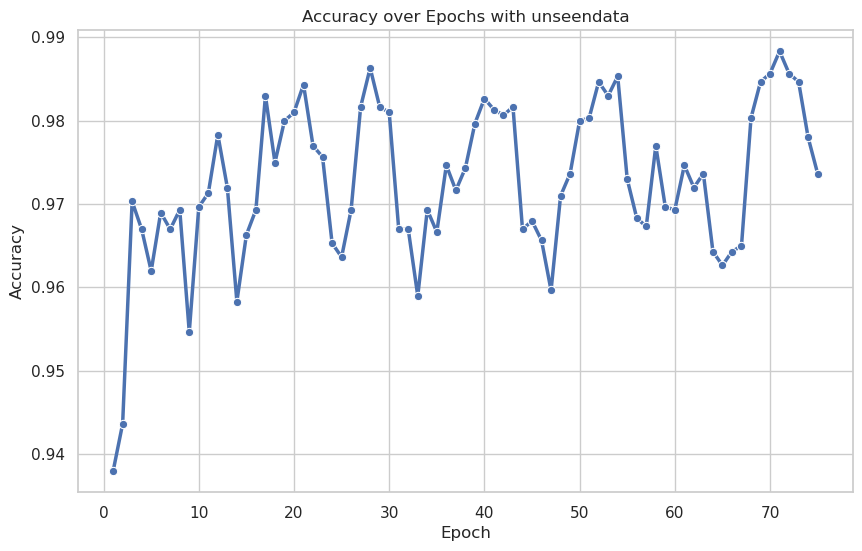

In [9]:
C = flattened_data.shape[1]
T = np.power((C/0.8377),1/2.2099)
s = 2.534*np.log((C/3.7579))

# Split your combined dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flattened_data, repeated_y_data, test_size=0.2)

training_steps = 75
epochs = 1
runs = 1 # Number of runs in total the Tsetlin Machine will do

for i in range(runs):
    epoch_accuracies = []
    epoch_unseen = []
    tm = MultiClassConvolutionalTsetlinMachine2D(int(C), T, s,(int(flattened_data.shape[1]),bits)) # Init the Tsetlin Machine
    for epoch in range(training_steps):
        tm.fit(X_train, y_train, epochs=epochs, incremental=True)  # Train for epoch
        
        Y_pred = tm.predict(X_test)
    
        y_test = y_test.astype(Y_pred.dtype)
        
        #print(f"y_test dtype: {y_test.dtype}, Y_pred dtype: {Y_pred.dtype}")
        accuracy = accuracy_score(y_test, Y_pred)
        print(f'Epoch {epoch+1} Accuracy: {accuracy * 100:.2f}%')
        epoch_accuracies.append(accuracy)
        a_s = accuracy
    
        repeated_y_data_test = repeated_y_data_test.astype(Y_pred.dtype)
        Y_pred = tm.predict(flattened_data_test)
        accuracy = accuracy_score(repeated_y_data_test, Y_pred)
        print(f'Epoch {epoch+1} Accuracy for unseendata: {accuracy * 100:.2f}%')
        epoch_unseen.append(accuracy)
        a_u = accuracy
        
        accuracy_data = {
            "epoch_accuracies": epoch_accuracies,
            "epoch_unseen": epoch_unseen
        }

        try:
            with open(json_file, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            data = {'training_run': [],}
            with open(json_file, 'w') as file:  
                json.dump(data, file)  

        data['training_run'].append({
            'seendata': a_s,
            'unseendata': a_u,
        })
        
        with open(json_file, 'w') as f:
            json.dump(data, f, indent=4)
    

# Now you can plot the accuracy over epochs if you want
data = pd.DataFrame({
    'Epoch': range(1, training_steps + 1),
    'Accuracy': epoch_accuracies
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.lineplot(x='Epoch', y='Accuracy', data=data, marker='o', palette="tab10", linewidth=2.5)
plot.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy over Epochs')
# plt.savefig('../plot/accuracy_plot.png')  # Option for saving plot
plt.show()

data_unseen = pd.DataFrame({
    'Epoch': range(1, training_steps + 1),
    'Accuracy': epoch_unseen
})
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.lineplot(x='Epoch', y='Accuracy', data=data_unseen, marker='o', palette="tab10", linewidth=2.5)
plot.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy over Epochs with unseendata')
# plt.savefig('../plot/accuracy_plot_unseen.png')  # Option for saving plot

plt.show()

Confusion Matrix:
[[7861   19  112]
 [  32 7958    2]
 [ 115    2 7875]]


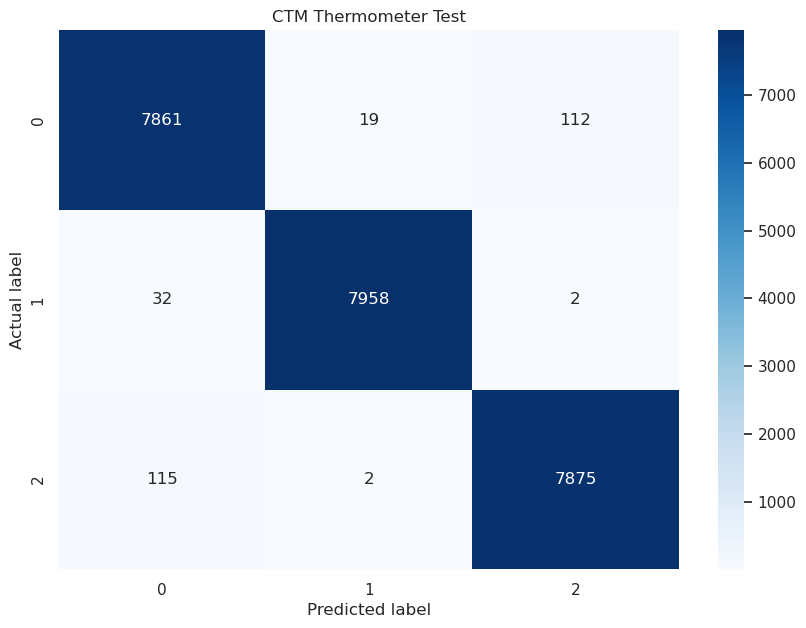

Confusion Matrix:
[[920  79   0]
 [  0 999   0]
 [  0   0 999]]


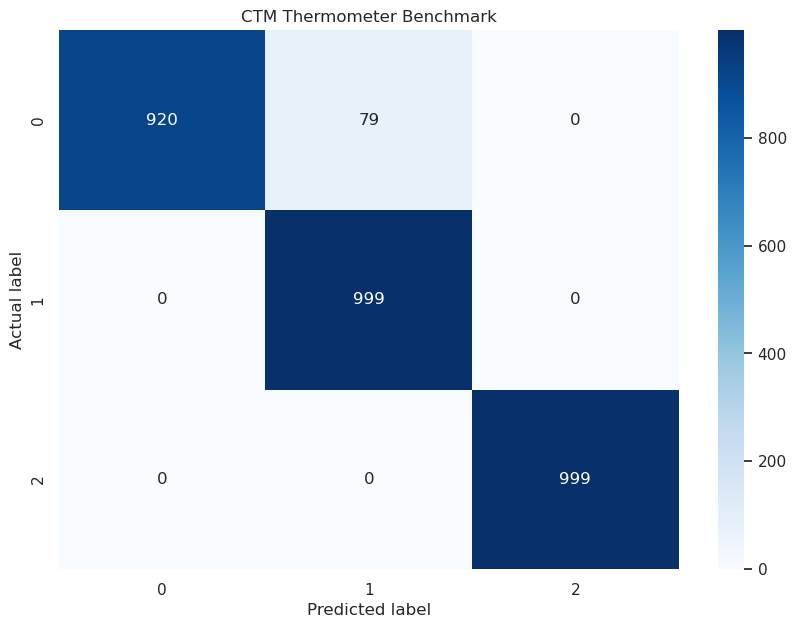

In [10]:
Y_pred = tm.predict(flattened_data)
repeated_y_data = repeated_y_data.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(repeated_y_data, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title('CTM Thermometer Test')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.savefig('../plot/CM_CWRU_CTM_thermometer_test.pdf') # Option for saving plot
plt.show()


Y_pred = tm.predict(flattened_data_test)
repeated_y_data_test = repeated_y_data_test.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(repeated_y_data_test, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title('CTM Thermometer Benchmark')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.savefig('../plot/CM_CWRU_CTM_thermometer_benchmark.pdf') # Option for saving plot
plt.show()

In [11]:
print(C)
print(T)
print(s)

490
17.870698542251617
12.341961284328281
